# Linear Regression

In this notebook, we will apply machine learning to make predictions about Internet of Things (IoT) devices and Internet Web traffic. First, we will explore the use of linear regression, a common linear model to capture linear relationships between sets of features and target variables we would like to predict.

We will also briefly look at polynomial basis expansion, a way to extend linear models to capture certain types of non-linear relationships between features and target variables.

### Linear Regression

Suppose we have a list of 2D points, where the $x$ value of each point is the number of hours per day a different IoT device is on, and the $y$ value of the point is the energy consumed by the device (in Wh).

In [1]:
# Machine Learning Libraries
import numpy as np
import pandas as pd
from sklearn import linear_model

# Plotting Library
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,6)

# Allow us to load modules from the parent directory
import sys
sys.path.append("../lib") 

# Libraries for Processing Network Traffic
import ipaddress
import netaddr
from parse_pcap import pcap_to_pandas, pcap_to_dict

### Create and Visualize the Dataset

Create an example set of points representing our IoT energy usage dataset: 
* $x$ values will represent hours used, and 
* $y$ values will represent total energy usage (Wh).

In [2]:
# Create an example set of points (toy example).
points = np.asarray([(1,20), (5,40), (3,70), (4,50), (1.5,40), (2,30), (6,80), (7,70), (8,90), (10,80)])
points

array([[ 1. , 20. ],
       [ 5. , 40. ],
       [ 3. , 70. ],
       [ 4. , 50. ],
       [ 1.5, 40. ],
       [ 2. , 30. ],
       [ 6. , 80. ],
       [ 7. , 70. ],
       [ 8. , 90. ],
       [10. , 80. ]])

We can plot these points using `matplotlib`.

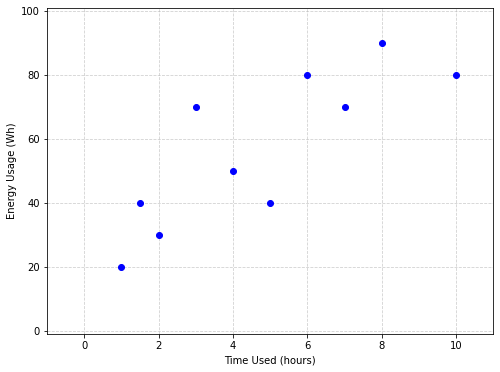

In [3]:
plt.plot(points[:,0], points[:,1], '.', color='blue', markersize=12)
plt.grid(linestyle='--', alpha=0.6)
plt.xlabel('Time Used (hours)')
plt.ylabel('Energy Usage (Wh)')
plt.xlim((-1,11))
plt.ylim((-1,101))
plt.show()

### Linear Regression by Hand

Now suppose that we want to draw a line that goes through the middle of the collection of points with minimal distance between the line and each point along the y-axis. The equation for a line is $y=mx+b$, where $m$ is the slope of the line and $b$ is the $y$-intercept. The following code plots a line in addition to the points from before. Change the values of $m$ and $b$ to find a line with the smallest total distance to the points. When you've found good values for $m$ and $b$, raise your hand.

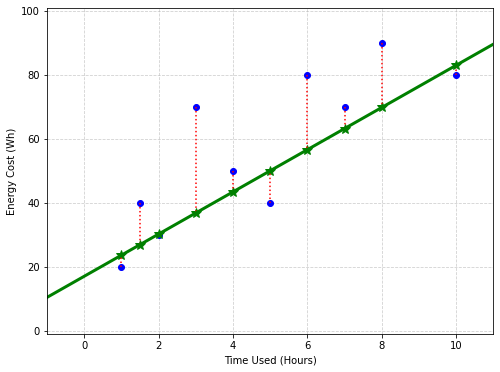

In [4]:
####################
# MANUAL SETTING OF LINEAR COEFFICIENTS
# y = m*x + b
m = 6.6
b = 17
####################

# Calculate the distances from the line to the points

# x and y values of the points
points_x, points_y = points[:,0], points[:,1] 

# predicted y values of the line at the x values of the points
y_hat = m * points_x + b                     

# Plot the line and points
plt.plot(points_x, points_y, '.', color='blue', markersize=12)
plt.plot(points_x, y_hat, '*', color='green', markersize=10)
for px, py, yh in zip(points_x, points_y, y_hat):
    plt.plot([px, px], [py, yh], ':', color='red', linewidth=1.5)
plt.plot([-2, 12], np.array([-2,12])*m + b, '-', color='green', linewidth=3)
plt.grid(linestyle='--', alpha=0.6)
plt.xlim((-1, 11))
plt.ylim((-1, 101))
plt.xlabel('Time Used (Hours)')
plt.ylabel('Energy Cost (Wh)')
plt.show()

### Evaluation: Error Computation

You can compute how well your manual fit is by computing the error, in terms of residual sum of squares.

In [5]:
# Compute Least Squared Error
distances = np.sqrt((points_y - y_hat)**2)   # distances from y values of the points to y values of the line
total_distance = np.sum(distances)            # sum of the distances
print("Residual Sum of Squares (RSS): {:.4f}".format(total_distance))

Residual Sum of Squares (RSS): 120.1000


Congratulations! You've done linear regression by hand! 

### Linear Regression Using Python Scikit-Learn

Fortunately, there are Python functions which will find the best line for us, so we don't have to do it manually.
The following code plots the points, your line in green, and the optimal line determined by the Python LinearRegression function in red. 

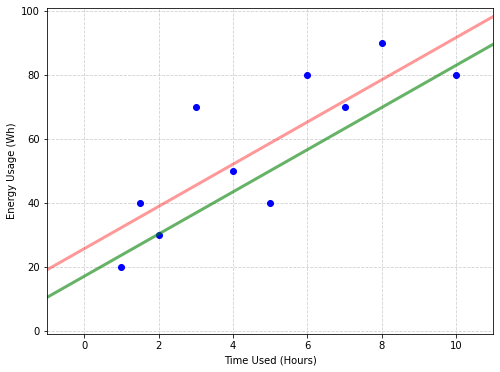

In [6]:
###########
# Step 1: Create Linear Regression Model
linear_regression = linear_model.LinearRegression()

# Step 2: Train the Model Using the (x,y) Points
# Note: Reshape (-1,1) creates a column vector ("x transpose"), which is what fit() expects.
linear_regression.fit(points_x.reshape(-1,1), points_y)

# Step 3: Input to predict function are x values that the model has never seen.
y_hat = linear_regression.predict(np.array([-2,12]).reshape(-1,1))
###########

# Plot the results along with the points and previous line
# Plot the original points.
plt.plot(points_x, points_y, '.', color='blue', markersize=12)

# Manual Linear Regression from before is in green.
plt.plot([-2, 12], np.array([-2,12])*m + b, '-', color='green', linewidth=3, alpha=0.6)

# Predicted line from sklearn is in red
plt.plot([-2, 12], y_hat, color='red', alpha=0.4, linewidth=3)

plt.grid(linestyle='--', alpha=0.6)
plt.xlim((-1, 11))
plt.ylim((-1, 101))
plt.xlabel('Time Used (Hours)')
plt.ylabel('Energy Usage (Wh)')
plt.show()

In [7]:
# m (slope)
linear_regression.coef_

array([6.60465116])

In [8]:
# b (intercept)
linear_regression.intercept_

25.627906976744192

So why is this useful? Suppose someone is thinking about buying a new device, which will be on for 9 hours a day, and wants to know how much the energy running the device will use. 
* We can use the $y$-value of the line at $x = 9$ to predict the cost. 
* We could repeat this prediction for any new value of $x$ and obtain a reasonable energy usage prediction.

In [9]:
# New Input Variable
hours_on = 9

# Target Prediction
predicted_cost = linear_regression.predict([[hours_on]])
print("Predicted energy cost of device with {0} hours on per day: {1:.2f} Wh".format(hours_on, predicted_cost[0]))

Predicted energy cost of device with 9 hours on per day: 85.07 Wh


In [10]:
from sklearn.metrics import mean_squared_error

mean_squared_error(points_y, linear_regression.predict(points_x.reshape(-1,1)))

169.30232558139534

### Polynomial Basis Expansion

Recall that one of the benefits of a polynomial feature expansion is that it is possible to fit a linear model to the resulting polynomial expansion.

We will do that below.  Let's first create the regular features and then the polynomial expansion.

In [11]:
# Polynomial Features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_x = poly.fit_transform(points_x.reshape(-1,1))
poly_x

array([[   1.   ,    1.   ,    1.   ],
       [   5.   ,   25.   ,  125.   ],
       [   3.   ,    9.   ,   27.   ],
       [   4.   ,   16.   ,   64.   ],
       [   1.5  ,    2.25 ,    3.375],
       [   2.   ,    4.   ,    8.   ],
       [   6.   ,   36.   ,  216.   ],
       [   7.   ,   49.   ,  343.   ],
       [   8.   ,   64.   ,  512.   ],
       [  10.   ,  100.   , 1000.   ]])

In [12]:
# Train the Model Using a Polynomial Expansion of the (x,y) Points.
linear_regression.fit(poly_x, points_y)

# Generate Predictions: Input to predict function are x values that the model has never seen.
y_hat2 = linear_regression.predict(poly.fit_transform(np.arange(-2,12,1).reshape(-1,1)))
y_hat2

array([-7.54228602,  4.60491414, 16.21606218, 27.2026448 , 37.47614871,
       46.94806061, 55.52986722, 63.13305523, 69.66911136, 75.04952232,
       79.18577482, 81.98935555, 83.37175124, 83.24444858])

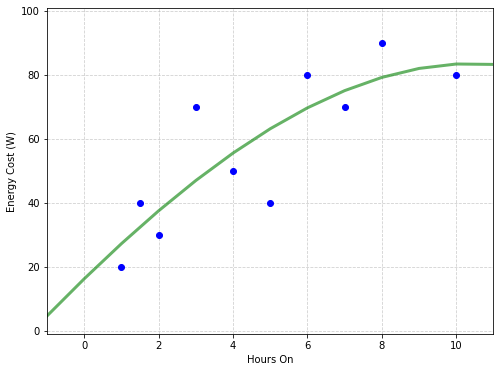

In [13]:
###########

# Plot the results along with the points and previous line
# Plot the original points.
plt.plot(points_x, points_y, '.', color='blue', markersize=12)

# Plot the results along with the points and previous line
# Plot the original points.
plt.plot(np.arange(-2,12,1), y_hat2,  '-', color='green', linewidth=3, alpha=0.6)

plt.grid(linestyle='--', alpha=0.6)
plt.xlim((-1, 11))
plt.ylim((-1, 101))
plt.xlabel('Hours On')
plt.ylabel('Energy Cost (W)')
plt.show()

In [14]:
mean_squared_error(points_y, linear_regression.predict(poly.fit_transform(points_x.reshape(-1,1))))

152.26649778701983

### Bias-Variance Tradeoff and Overfitting

The above model has some potential for what is called overfitting.

---
## Other Features and Inputs

Of course, there are many factors which affect energy consumption apart from the length of time a device is powered on. Raise your hand if you can think of some reasons why this predicted cost might not be accurate.

However, given that the only information we have about these hypothetical devices are hours on, the linear regression line gives us the highest probability prediction possible assuming a linear relationship between hours on and energy cost. 

---

## Applying Linear Regression to Network Traffic

We can apply linear regression to network traffic, by exploring the relationship between packets and bytes.  

First, let's load one of the example datasets.  Then, we can plot some of the relationships as above and then use scikit-learn's `LinearRegression` object to fit the best line through these points.  Once we have done that, we can use the number of packets as a feature and predict the number of bytes (or, if you prefer, vice versa).

### Load the Network Traffic Data

In [15]:
import sys
sys.path.append("../lib") 
from parse_pcap import pcap_to_pandas, send_rates

pcap = pcap_to_pandas('../pcaps/uchicagocs-web-20200714.pcap')

### Extract the Columns of Interest

A "flow" in network traffic is the "five tuple" of source and destination IP address and port, as well as protocol.  We can exteact just those five-tuples

In [16]:
pdf = pcap.loc[:,['ip_src','ip_dst','length','port_src','port_dst','protocol']]
pdf.head(5)

,ip_src,ip_dst,length,port_src,port_dst,protocol
0,192.168.1.13,128.135.164.125,78,53469,443,TCP
1,128.135.164.125,192.168.1.13,66,443,53469,TCP
2,192.168.1.13,128.135.164.125,54,53469,443,TCP
3,192.168.1.13,128.135.164.125,571,53469,443,TCP
4,128.135.164.125,192.168.1.13,60,443,53469,TCP


### Create Features

Create features for packets and bytes by grouping counts (packets) and length (bytes) by each five-tuple.

In [17]:
pdf_bytes = pdf.groupby(['ip_src','ip_dst','port_src','port_dst','protocol']).sum()
pdf_pkts = pdf.groupby(['ip_src','ip_dst','port_src','port_dst','protocol']).count()

In [18]:
pkts = pdf_pkts['length'].values
byte = pdf_bytes['length'].values

points_x = pkts
points_y = byte

### Train a Linear Regression Model

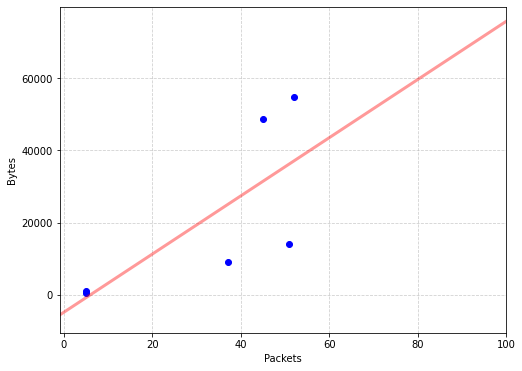

In [19]:
###########
# Step 1: Create Linear Regression Model
linear_regression = linear_model.LinearRegression()

# Step 2: Train the Model Using the (x,y) Points
# Note: Reshape (-1,1) creates a column vector, which is what fit() expects.
linear_regression.fit(points_x.reshape(-1,1), points_y)

# Step 3: Input to predict function are x values that the model has never seen.
y_hat = linear_regression.predict(np.array([-2,100]).reshape(-1,1))
###########

# Plot the results along with the points and previous line
# Plot the original points.
plt.plot(points_x, points_y, '.', color='blue', markersize=12)

# Predicted line from sklearn is in red
plt.plot([-2, 100], y_hat, color='red', alpha=0.4, linewidth=3)

plt.grid(linestyle='--', alpha=0.6)
plt.xlim((-1, 100))
plt.xlabel('Packets')
plt.ylabel('Bytes')
plt.show()